In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mplfinance as mpf
import pickle

In [2]:
## drift coefficent
mu = 0.5
## number of steps
n = 10002
## time in years
T = 10
## number of sims
M = 100
# initial stock price
S0 = 100
#volatility
sigma = 0.7


# $$ S_{t} = S_{0}e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_{t}}$$

In [3]:
## calc ecch time step
dt = T/n

St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(M, n)).T
)

St = np.vstack([np.ones(M), St])

St = S0 * St.cumprod(axis=0)

In [4]:
time = np.linspace(0, T, n + 1)

tt = np.full(shape=(M, n+1), fill_value=time).T

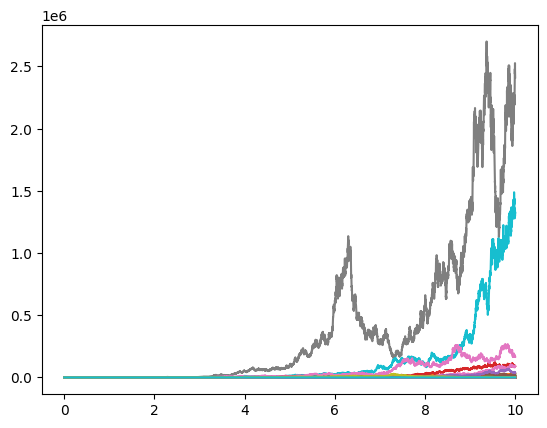

In [5]:
plt.plot(tt, St)
plt.show()

In [6]:
def to_candel(idx, St):
    ts1 = St[:, idx]
    ts1 = ts1.reshape(-1, 7)
    Low = np.min(ts1, axis=1)
    High = np.max(ts1, axis=1)
    Open = ts1[:, 0]
    Close = ts1[:, -1]
    return np.vstack((Open, High, Low, Close))

In [8]:
to_candel(0, St).shape

(4, 1429)

In [7]:
def plot(idx, St):
    OHLC = to_candel(idx, St)
    
    # Sample OHLC data without timestamps and volume
    data = {
        'Open':OHLC[0],
        'High':OHLC[1], 
        'Low': OHLC[2], 
        'Close': OHLC[3]
    }
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    
    # Create a dummy date range to use as an index
    df.index = pd.date_range(start="2023-01-01", periods=len(df), freq="D")
    
    # Plot the candlestick chart
    # add_plot = mpf.make_addplot(df['Close'], color='blue', linestyle='-')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    mpf.plot(df, type='candle', style='yahoo', ax=ax1)
    ax2.plot(tt, St[:, idx])
    plt.plot()

/usr/local/python/3.12.1/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


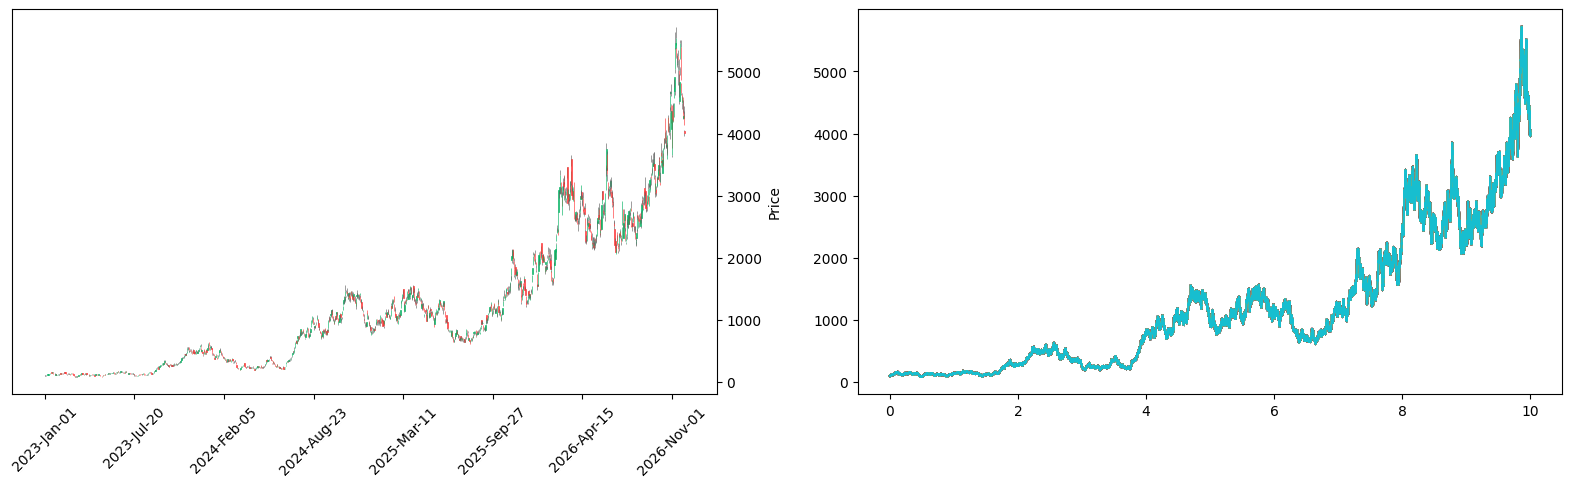

In [8]:
plot(1, St)

In [9]:
class STC:
    def __init__(self, mat, idx):
        self.mat = mat
        self.idx = idx
        if idx > 7:
            self.trend = self.mat[3][idx - 8: idx]
        else:
            raise(ValueError("index must be greater that 7"))
    def get_trend(self, idx):
        if idx > 7:
            return self.mat[3][idx - 8: idx]
        else:
            "pass"
    def get_sub_trend(self, pos):
        if pos < 4:
            x = self.trend[pos: pos + 5]
            return x
        else:
            raise(ValueError("position must be less than 3"))
    def ap(self, pos):
        return np.mean(self.get_sub_trend(pos))
    def price_trend(self):
        aps = [self.ap(0),
              self.ap(1),
              self.ap(2), 
              self.ap(3)]
        if (aps[0] < aps[1] < aps[2] < aps[3]):
        # if all(aps[i] < aps[i + 1] for i in range(len(aps) - 1)): 
            return 1
        elif (aps[0] > aps[1] > aps[2] > aps[3]):
            return -1
        else:
            return 0
class S:
    def __init__(self, mat, idx, length):
        self.mat = np.moveaxis(mat, 0, 1)
        self.idx = idx
        self.stc = STC(mat, idx)
        self.length = length
        self.pattern = self.mat[idx:idx + length, :] 
    # def slice(self, length):
    #     return self.mat[self.idx: self.idx + length, :]
    def get_trend(self):
        return self.stc.get_trend()
    def values(self):
        # return self.mat[self.idx - 8: self.idx + self.length, :]
        return self.mat[self.idx - 8: self.idx + 3, :]
    def ap(self):
        return self.stc.ap()
    def price_trend(self):
        return self.stc.price_trend()
    
    def op(self, i):
        return self.pattern[i][0]
    def cp(self, i):
        return self.pattern[i][3]
    def hp(self, i):
        return self.pattern[i][1]
    def lp(self, i):
        return self.pattern[i][2]

    def sli_greater(self, x, y):
        ratio = (x - y) / y
        return 0.003 <= ratio < 0.01
    def lar_less(self, x, y):
        ratio = (y - x) / x
        return 0.025 <= ratio < 0.05
    def ext_near(self, x, y):
        numerator = np.absolute(x - y)
        denominator = np.maximum(x, y)
        return (numerator / denominator) <= 0.003
        
    
    def white_body(self, i):
        return self.pattern[i][0] < self.pattern[i][3]
    def long_white_body(self, i):
        return self.long_body(i) & self.white_body(i)
    def long_black_body(self, i):
        return self.long_body(i) & self.black_body(i)
    def black_body(self, i):
        return self.op(i) > self.cp(i)
    def small_body(self, i):
        return self.sli_greater(self.tp_body(i), self.bm_body(i))
    def long_body(self, i):
        return self.lar_less(self.bm_body(i), self.tp_body(i))
    def small_us(self, i):
        return self.sli_greater(self.hp(i), self.tp_body(i))
    def no_ls(self, i):
        return self.ext_near(self.lp(i), self.bm_body(i))
    def no_us(self, i):
        return self.ext_near(self.hp(i), self.tp_body(i))
    def long_ls(self, i):
        return self.lar_less(self.lp(i), self.bm_body(i))

    def down_body_gap(self, i, j):
        return self.bm_body(i) > self.tp_body(j)
    def up_body_gap(self, i, j):
        return self.tp_body(i) < self.bm_body(j)
       
    def tp_body(self, i):
        x = np.maximum(self.op(i), self.cp(i))
        return x
    def bm_body(self, i):
        return np.minimum(self.op(i), self.cp(i))
        
    def us(self, i):
        return self.hp(i) - self.tp_body(i)
    def ls(self, i):
        return self.bm_body(i) - self.lp(i)
    def hs(self, i):
        return self.us(i) + self.ls(i)
    def hb(self, i):
        return np.absolute(self.cp(i) - self.op(i))
    

In [ ]:
class EveningStar:
    def __init__(self, mat, idx):
        self.s = S(mat, idx=idx, length=3)
        self.label = "Evening Star"
    def check(self):
        return (self.s.price_trend() == 1) & self.s.long_white_body(0) & \
        self.s.small_body(1) & self.s.up_body_gap(0, 1) & self.s.down_body_gap(1, 2) & \
        self.s.long_black_body(2) & (self.s.cp(2) > self.s.op(0)) & \
        (self.s.op(0) < self.s.cp(2) <= (0.5*(self.s.op(0) + self.s.cp(0))))

class MorningStar:
    def __init__(self, mat, idx):
        self.s = S(mat, idx=idx, length=3)
        self.label = "Morning Star"
    def check(self):
        return (self.s.price_trend() == -1) & self.s.long_black_body(0) & \
        self.s.small_body(1) & self.s.down_body_gap(0, 1) & self.s.long_white_body(2) & \
        self.s.up_body_gap(1, 2) & (self.s.cp(2) > (0.5*(self.s.op(0) + self.s.cp(0))))

class EngulfingBearish:
    def __init__(self, mat, idx):
        self.s = S(mat, idx=idx, length=2)
        self.label = "Engulfing Bearish"
    def check(self):
        return (self.s.price_trend() == 1) & self.s.white_body(0) & self.s.black_body(1) & \
        (self.s.op(0) > self.s.cp(1)) & (self.s.op(1) > self.s.cp(0))

class EngulfingBullish:
    def __init__(self, mat, idx):
        self.s = S(mat, idx=idx, length=2)
        self.label = "Engulfing Bullish"
    def check(self):
        return (self.s.price_trend() == -1) & self.s.black_body(0) & self.s.white_body(1) & \
        (self.s.cp(0)> self.s.op(1)) & (self.s.cp(1) > self.s.op(0))

class AdvancedBlock:
    def __init__(self, mat, idx):
        self.s = S(mat, idx=idx, length=3)
        self.label = "Advance Block"
    def check(self):
        return (self.s.price_trend() == 1) & self.s.white_body(0) & self.s.white_body(1) & self.s.white_body(2) &\
        (self.s.op(0) < self.s.op(1) < self.s.cp(0)) & \
        (self.s.op(1) < self.s.op(2) < self.s.cp(1)) & \
        (self.s.hs(2) > self.s.hb(2)) & \
        (self.s.hs(1) > self.s.hb(1)) & \
        (self.s.hs(2) > self.s.hs(0)) & \
        (self.s.hs(1) > self.s.hs(0))

class Hammer:
    def __init__(self, mat, idx):
        self.s = S(mat, idx=idx, length=1)
        self.label = "Hammer"
    def check(self):
        return ~(self.s.no_ls(0)) & (self.s.price_trend() == -1) & self.s.small_body(0) & \
        (2*self.s.hb(0) < self.s.ls(0) < 3*self.s.hb(0)) & (self.s.small_us(0) | self.s.no_us(0))

class HangingMan:
    def __init__(self, mat, idx):
        self.s = S(mat, idx=idx, length=1)
        self.label = "Hanging Man"
    def check(self):
        return (self.s.price_trend() == 1) & self.s.small_body(0) & self.s.long_ls(0) & self.s.no_us(0)

In [17]:
def print_pattern(temp):
    data = {
            'Open':temp[0],
            'High':temp[1], 
            'Low': temp[2], 
            'Close': temp[3]
        }
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    
    # Create a dummy date range to use as an index
    df.index = pd.date_range(start="2023-01-01", periods=len(df), freq="D")
    
    # Plot the candlestick chart
    mpf.plot(df, type='candle', style='yahoo')

In [18]:
count = 0
features = []
labels = []
patterns = [AdvancedBlock, EngulfingBearish, EngulfingBullish, HangingMan, Hammer, MorningStar, EveningStar]
obj_collection = []
for j in range(100):
    mat = to_candel(j, St)
    for cls in patterns:
        for i in range(8, mat.shape[1] - 3):
            # obj = AdvancedBlock(mat, i)
            # obj = EngulfingBearish(mat, i)
            # obj = EngulfingBullish(mat, i)
            # obj = HangingMan(mat, i)
            # obj = MorningStar(mat, i)
            # obj = EveningStar(mat, i)
            obj = cls(mat, i)
            if obj.check():
                obj_collection.append(obj)
                temp = obj.s.values()
                features.append(temp)
                labels.append(obj.label)
                # temp = np.moveaxis(obj.s.values(), 1, 0)
                # print_pattern(temp)
                count = count + 1
features = np.array(features)
labels = np.array(labels)
print(count)
print(features.shape)

4989
(4989, 11, 4)


In [19]:
[(obj_collection[1].s.stc.ap(i),obj_collection[1].s.stc.get_sub_trend(i)) for i in range(4)]
# [obj_collection[1].s.stc.get_sub_trend(i) for i in range(4)]

[(np.float64(20.853384157514846),
  array([19.86994795, 20.57544717, 20.7731577 , 22.11740427, 20.93096369])),
 (np.float64(21.766897189783286),
  array([20.57544717, 20.7731577 , 22.11740427, 20.93096369, 24.43751311])),
 (np.float64(22.546333928505028),
  array([20.7731577 , 22.11740427, 20.93096369, 24.43751311, 24.47263086])),
 (np.float64(22.7546880171435),
  array([22.11740427, 20.93096369, 24.43751311, 24.47263086, 21.81492815]))]

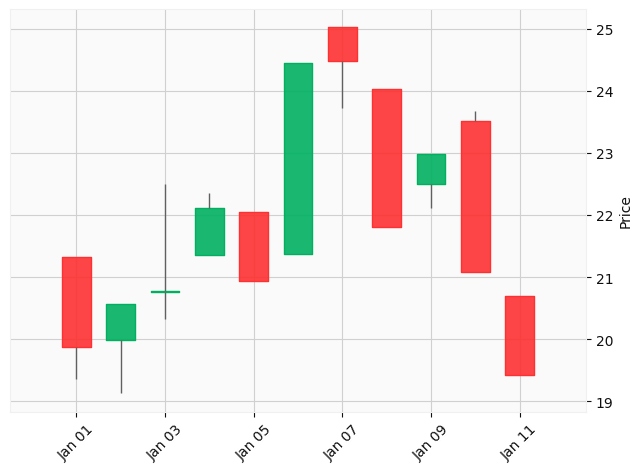

Engulfing Bearish


In [22]:
def test(i):
    print_pattern(np.moveaxis(features[i], 1, 0))
    print(labels[i])
test(1)

In [23]:
np.unique(labels, return_counts=True)

(array(['Advance Block', 'Engulfing Bearish', 'Engulfing Bullish',
        'Evening Star', 'Hammer', 'Hanging Man', 'Morning Star'],
       dtype='<U17'),
 array([  47, 2110, 1880,    5,  282,  658,    7]))

In [24]:
dataset = (features, labels)
with open('synthetic_data.pkl', 'wb') as f:
    pickle.dump(dataset, f)